# Overview
This notebook is used to create a regression model that predicts the median house price within a block based on a number of features. The dataset used is the "California Housing Prices" dataset which is available at https://www.kaggle.com/datasets/camnugent/california-housing-prices/data. Here is a summary of the Kaggle description of the dataset:

The dataset discussed is initially featured in the paper "Sparse Spatial Autoregressions" by R. Kelley Pace and Ronald Barry, published in the Statistics & Probability Letters, 33 (1997) 291-297. The author of the Kaggle project encountered this dataset in the second chapter of Aurélien Géron's book, "Hands-On Machine Learning with Scikit-Learn and TensorFlow." This dataset was a modified version of the California Housing dataset available at Luís Torgo's page (University of Porto) http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html.
    
This dataset contains information about houses in California districts derived from the 1990 California census. While it may not be suitable for predicting current housing prices, it serves as a great introduction for building machine learning models due to its need for basic data cleaning, a clear and easily comprehensible list of features, and an optimal size that strikes a balance between being overly simplistic and excessively complex.

The dataset contains 20640 rows and 10 columns. The columns are as follows:
1. longitude (float): A measure of how far west a house is; a higher value is farther west
2. latitude (float): A measure of how far north a house is; a higher value is farther north
3. housing_median_age (float): Median age of houses within a block; a lower number is a newer building
4. total_rooms (float): Total number of rooms within a block
5. total_bedrooms (float): Total number of bedrooms within a block
6. population (float): Total number of people residing within a block
7. households (float): Total number of households, a group of people residing within a home unit, for a block
8. median_income (float): Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. median_house_value (float, target): Median house value for households within a block (measured in US Dollars)
10. ocean_proximity (string): Location of the house w.r.t. ocean/sea

This notebook performs the following steps to create a regression model:
1. Data Exploration
2. Data Preprocessing
3. Model Training and Evaluation

The creation of this notebook has taken inspiration from the following sources:
- Aurélien Géron's "02_end_to_end_machine_learning_project.ipynb" python notebook in "handson-ml2" git repository. https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
- Andrey Shtrauss's "Bayesian Regression | House Price Prediction" python notebook in Kaggle. https://www.kaggle.com/code/shtrausslearning/bayesian-regression-house-price-prediction#5-|-FEATURE-ENGINEERING



# Install Python Packages/Libraries

Install the specified Python packages. Here's a breakdown of each package:

`joblib`: A set of tools for pipelining Python jobs. It provides utilities for saving and loading Python objects that make it possible to save scikit-learn models in a format that can be used in production.

`matplotlib`: A plotting library for creating visualizations in Python. It is often used in conjunction with other libraries for data analysis and machine learning.

`numpy`: A fundamental package for scientific computing with Python. It provides support for large, multi-dimensional arrays and matrices, along with mathematical functions to operate on these arrays.

`pandas`: A powerful data manipulation and analysis library. It provides data structures for efficiently storing and manipulating large datasets.

`seaborn`: A statistical data visualization library based on Matplotlib. It provides a high-level interface for creating informative and attractive statistical graphics.

`scikit-learn`: A machine learning library that provides simple and efficient tools for data analysis and modeling. It includes various algorithms for classification, regression, clustering, and more.


In [12]:
%pip install joblib==1.3.2 matplotlib==3.7.1 numpy==1.23.5 pandas==1.5.3 plotly==5.15.0 scikit-learn==1.2.2 seaborn==0.13.1 "nbformat>=4.2.0"

Note: you may need to restart the kernel to use updated packages.


# Import Packages/Libraries

In addition to the packages/libraries installed above, we will also imported

`typing`: A module that provides support for type hints. Type hints allow you to specify the type of a variable, function parameter, or return value. This helps improve the readability of your code and allows you to catch errors early.

In [13]:
from typing import List, Tuple
import zipfile
import os
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer


# Data Exploration

We want to explore the data to get a better understanding of the dataset. We will use the pandas library to load the dataset into a pandas DataFrame. A DataFrame is a two-dimensional data structure that can store data of different types (including characters, integers, floating point values, categorical data, and more) in columns. It is similar to a spreadsheet or an SQL table. The DataFrame object also has powerful built-in methods for exploring and manipulating these data sets. We will first take a look at the structure of the dataset. Then, we want to explore the data to see if there are any missing values and to see if there are any skewness and outliers. We also want to see if there are any correlations between the features and the target variable. We will use the pandas library to load the dataset and the matplotlib, seaborn, and plotly library to plot the data.

Load the `housing.csv` file into a Pandas DataFrame using the `read_csv()` function. The `read_csv()` function takes in the path to the CSV file as a parameter and returns a DataFrame.

In [14]:
!unzip dataset.zip -d dataset # Unzip the file if needed.

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [15]:
csv_path = os.path.join('.','dataset/housing/housing.csv') # TODO: create variable for dataset path
df = pd.read_csv(csv_path) # Read dataset into dataframe

Display the first 5 rows of the dataframe using `head()` method of the dataframe.

We can see that the data contains 10 columns where the first 9 columns are numerical (continuous) values and the last column is a string (categorical) value. The target variable is the `median_house_value` column.

In [16]:
df.head(5) # Show the first 5 rows of dataframe

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

Obtain a concise summary of the dataframe. The `info()` method provides information about the dataframe, including the index range, the data types of each column, the number of non-null values, and memory usage.

In [17]:
df.info() # Show the info of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Retrieve the columns of the dataframe using the `columns` attribute of the dataframe.

In [18]:
df.columns # Show the columns of dataframe

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Retrieve the dimensions (rows, columns) of the dataframe using the `shape` attribute of the dataframe.

In [19]:
df.shape # Retrieve the number of rows and columns

(20640, 10)

Check and handles missing values in the Pandas DataFrame using the `isnull()` method of the dataframe. The `isnull()` method returns a boolean dataframe where each cell is either True or False depending on whether the corresponding cell in the dataframe is null or not. We can then use the `sum()` method to count the number of null values in each column.

In [20]:
# Check the number of missing values in each column
print('Missing values in each column:\n', df.isnull().sum(), sep='')
print('Original data shape: ', df.shape)
print('='*25)

# Print the rows with missing values and store the row indexes
null_rows = df[df.isnull().any(axis=1)]
null_rows_index = null_rows.index
print('Rows with missing values:\n')
null_rows


Missing values in each column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64
Original data shape:  (20640, 10)
Rows with missing values:



longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
290      -122.16     37.77                47.0       1256.0             NaN   
341      -122.17     37.75                38.0        992.0             NaN   
538      -122.28     37.78                29.0       5154.0             NaN   
563      -122.24     37.75                45.0        891.0             NaN   
696      -122.10     37.69                41.0        746.0             NaN   
...          ...       ...                 ...          ...             ...   
20267    -119.19     34.20                18.0       3620.0             NaN   
20268    -119.18     34.19                19.0       2393.0             NaN   
20372    -118.88     34.17                15.0       4260.0             NaN   
20460    -118.75     34.29                17.0       5512.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   

       population  households  median_income  median_house_value  \
290         570.0       218.0         4.3750            161900.0   
341         732.0       259.0         1.6196             85100.0   
538        3741.0      1273.0         2.5762            173400.0   
563         384.0       146.0         4.9489            247100.0   
696         387.0       161.0         3.9063            178400.0   
...           ...         ...            ...                 ...   
20267      3171.0       779.0         3.3409            220500.0   
20268      1938.0       762.0         1.6953            167400.0   
20372      1701.0       669.0         5.1033            410700.0   
20460      2734.0       814.0         6.6073            258100.0   
20484      1705.0       495.0         5.7376            218600.0   

      ocean_proximity  
290          NEAR BAY  
341          NEAR BAY  
538          NEAR BAY  
563          NEAR BAY  
696          NEAR BAY  
...               ...  
20267      NEAR OCEAN  
20268      NEAR OCEAN  
20372       <1H OCEAN  
20460       <1H OCEAN  
20484       <1H OCEAN  

[207 rows x 10 columns]

We have a few options to handle missing values:
- Option 1: We can drop the rows or columns that contain missing values using the `dropna()` method of the dataframe. The `dropna()` method takes in the axis to drop as a parameter. We can use the `axis` parameter to specify whether to drop rows or columns. By default, `axis=0` which drops the rows.
- Option 2: We can replace the missing values with the mean, median, or mode of the column. We will replace the missing values with the median of the column. We can use the `fillna()` method of the dataframe to replace the missing values with the median of the column. The `fillna()` method takes in the value to replace the missing values with as a parameter. We can use the `median()` method of the dataframe to obtain the median of the column.
- Option 3: We can replace the missing values with KNN imputation. KNN imputation is a method that uses the k-nearest neighbors algorithm to impute missing values. It works by finding the k-nearest neighbors of data points with missing values and then imputing the missing values with the mean of the neighbors. We will use the `KNNImputer()` from the `sklearn.impute` module to impute the missing values. The `KNNImputer()` takes in the number of neighbors and weights to use as a parameter. We will use 10 neighbors and weight points by the inverse of their distance. We can then use the `fit_transform()` method of the `KNNImputer()` object to impute the missing values. The `fit_transform()` method takes in the dataframe as a parameter and returns a numpy array. We can then convert the numpy array to a dataframe using the `DataFrame()` from the `pandas` library. Reference link for `KNNImputer()`: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

In [21]:
# Option 1: drop the rows with missing values
df_dropped_na = df.dropna()
print('Missing values after dropped na:\n', df_dropped_na.isnull().sum(), sep='')
print('Data shape after dropping nan:', df_dropped_na.shape)
print('='*25)

Missing values after dropped na:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64
Data shape after dropping nan: (20433, 10)


In [22]:
# Option 2: fill in the missing values with the median of the column
df_median_filled = df.fillna(df.median())
print('Missing values after filling with median values:\n', df_median_filled.isnull().sum(), sep='')
print('Data shape after filling with median values:', df_median_filled.shape)

# check the null rows again
print('Median values for each column:\n', df.median(), sep='')
df_median_filled.iloc[null_rows_index]

Missing values after filling with median values:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64
Data shape after filling with median values: (20640, 10)
Median values for each column:
longitude               -118.4900
latitude                  34.2600
housing_median_age        29.0000
total_rooms             2127.0000
total_bedrooms           435.0000
population              1166.0000
households               409.0000
median_income              3.5348
median_house_value    179700.0000
dtype: float64


/var/folders/3w/dx98vqrj12b47sl1fz6810rh0000gn/T/ipykernel_49330/1619758774.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_median_filled = df.fillna(df.median())
/var/folders/3w/dx98vqrj12b47sl1fz6810rh0000gn/T/ipykernel_49330/1619758774.py:7: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Median values for each column:\n', df.median(), sep='')


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
290      -122.16     37.77                47.0       1256.0           435.0   
341      -122.17     37.75                38.0        992.0           435.0   
538      -122.28     37.78                29.0       5154.0           435.0   
563      -122.24     37.75                45.0        891.0           435.0   
696      -122.10     37.69                41.0        746.0           435.0   
...          ...       ...                 ...          ...             ...   
20267    -119.19     34.20                18.0       3620.0           435.0   
20268    -119.18     34.19                19.0       2393.0           435.0   
20372    -118.88     34.17                15.0       4260.0           435.0   
20460    -118.75     34.29                17.0       5512.0           435.0   
20484    -118.72     34.28                17.0       3051.0           435.0   

       population  households  median_income  median_house_value  \
290         570.0       218.0         4.3750            161900.0   
341         732.0       259.0         1.6196             85100.0   
538        3741.0      1273.0         2.5762            173400.0   
563         384.0       146.0         4.9489            247100.0   
696         387.0       161.0         3.9063            178400.0   
...           ...         ...            ...                 ...   
20267      3171.0       779.0         3.3409            220500.0   
20268      1938.0       762.0         1.6953            167400.0   
20372      1701.0       669.0         5.1033            410700.0   
20460      2734.0       814.0         6.6073            258100.0   
20484      1705.0       495.0         5.7376            218600.0   

      ocean_proximity  
290          NEAR BAY  
341          NEAR BAY  
538          NEAR BAY  
563          NEAR BAY  
696          NEAR BAY  
...               ...  
20267      NEAR OCEAN  
20268      NEAR OCEAN  
20372       <1H OCEAN  
20460       <1H OCEAN  
20484       <1H OCEAN  

[207 rows x 10 columns]

In [23]:
# Option 3: use K-nearest neighbor imputation to fill in the missing values
# see https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
# for more details and parameters on the KNNImputer
imputer = KNNImputer(n_neighbors=10, weights='distance') # Create a KNNImputer object

# Separate the categorical and numerical columns as
# KNNImputer can only handle numerical columns
cat_cols = ['ocean_proximity']
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

# Impute the missing values in the numerical columns
# the imputer returns a numpy array with imputed values
df_num_filled = imputer.fit_transform(df[num_cols])

# Convert the imputed numpy array back to a pandas dataframe
df_num_filled = pd.DataFrame(df_num_filled, columns=num_cols)

# Concatenate the imputed numerical columns with the categorical columns
df_filled = pd.concat([df_num_filled, df[cat_cols]], axis=1)
print('Missing values after KNN impute:\n', df_filled.isnull().sum(), sep='')
print('Data shape after KNN impute:', df_filled.shape)

# check the null rows again
df_filled.iloc[null_rows_index]

Missing values after KNN impute:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64
Data shape after KNN impute: (20640, 10)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
290      -122.16     37.77                47.0       1256.0      249.926511   
341      -122.17     37.75                38.0        992.0      251.839495   
538      -122.28     37.78                29.0       5154.0     1176.259623   
563      -122.24     37.75                45.0        891.0      154.426267   
696      -122.10     37.69                41.0        746.0      183.786635   
...          ...       ...                 ...          ...             ...   
20267    -119.19     34.20                18.0       3620.0      810.993037   
20268    -119.18     34.19                19.0       2393.0      592.898368   
20372    -118.88     34.17                15.0       4260.0      691.056785   
20460    -118.75     34.29                17.0       5512.0      867.353661   
20484    -118.72     34.28                17.0       3051.0      652.484863   

       population  households  median_income  median_house_value  \
290         570.0       218.0         4.3750            161900.0   
341         732.0       259.0         1.6196             85100.0   
538        3741.0      1273.0         2.5762            173400.0   
563         384.0       146.0         4.9489            247100.0   
696         387.0       161.0         3.9063            178400.0   
...           ...         ...            ...                 ...   
20267      3171.0       779.0         3.3409            220500.0   
20268      1938.0       762.0         1.6953            167400.0   
20372      1701.0       669.0         5.1033            410700.0   
20460      2734.0       814.0         6.6073            258100.0   
20484      1705.0       495.0         5.7376            218600.0   

      ocean_proximity  
290          NEAR BAY  
341          NEAR BAY  
538          NEAR BAY  
563          NEAR BAY  
696          NEAR BAY  
...               ...  
20267      NEAR OCEAN  
20268      NEAR OCEAN  
20372       <1H OCEAN  
20460       <1H OCEAN  
20484       <1H OCEAN  

[207 rows x 10 columns]

Check the number of unique values in each column of dataframe using the `nunique()` method of the dataframe.

In [24]:
# Check the number of unique values in each column
df.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

From the `df.info()` and `df.head(5)` cell, we know that `ocean_proximity` is an object/string data type. We can use the `value_counts()` method to count the occurrences of each unique value in the column named `ocean_proximity`.

In [25]:
# Check the occurences of each unique value in the 'ocean_proximity' column
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

We can also display a pie chart to visualize the distribution of values in the `ocean_proximity` column using the `plot.pie()` method of the Pandas Series.

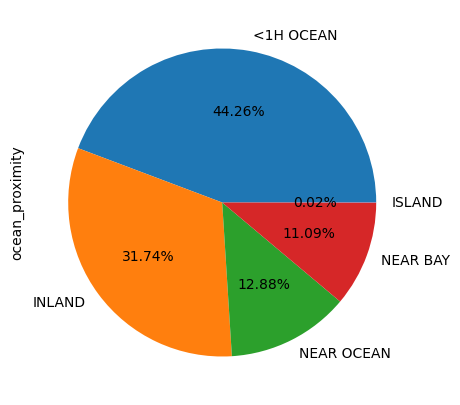

In [26]:
# Create a plt figure. Set the figure size and background color to white in case your editor GUI uses a dark theme
plt.figure(figsize=(5, 5), facecolor='white')

# Show the percentage of each category using a pie chart
# plot.pie() plots a pie chart on the figure attached to the current cell
# autopct='%1.2f%%' shows the percentage of each category with 2 decimal places
df['ocean_proximity'].value_counts().plot.pie(autopct='%1.2f%%')

plt.show()

Generate descriptive statistics of the numerical columns in the dataframe using the `describe()` method of the dataframe. The `describe()` method computes summary statistics of numerical columns, including count, mean, standard deviation, minimum, maximum, and the 25, 50, and 75 percentiles.

In [27]:
# Get the summary statistics of the numerical columns
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Visualize the distribution of the numerical columns in the dataframe using the `hist()` method of the dataframe. The `hist()` method creates a histogram for each numerical column in the dataframe. A histogram shows the frequency of values in a given range. The x-axis represents the value range and the y-axis represents the frequency of values in that range.

The histograms show that the features have very different scales. We will need to scale the features before training the model to avoid biasing the model towards features with larger values. We also see that some features (e.g. total_rooms, total_bedrooms, population, and households) are skewed due to the presence of outliers. We will transform the features using logarithmic scaling to reduce the skewness. We will perform these steps in the preprocessing section.

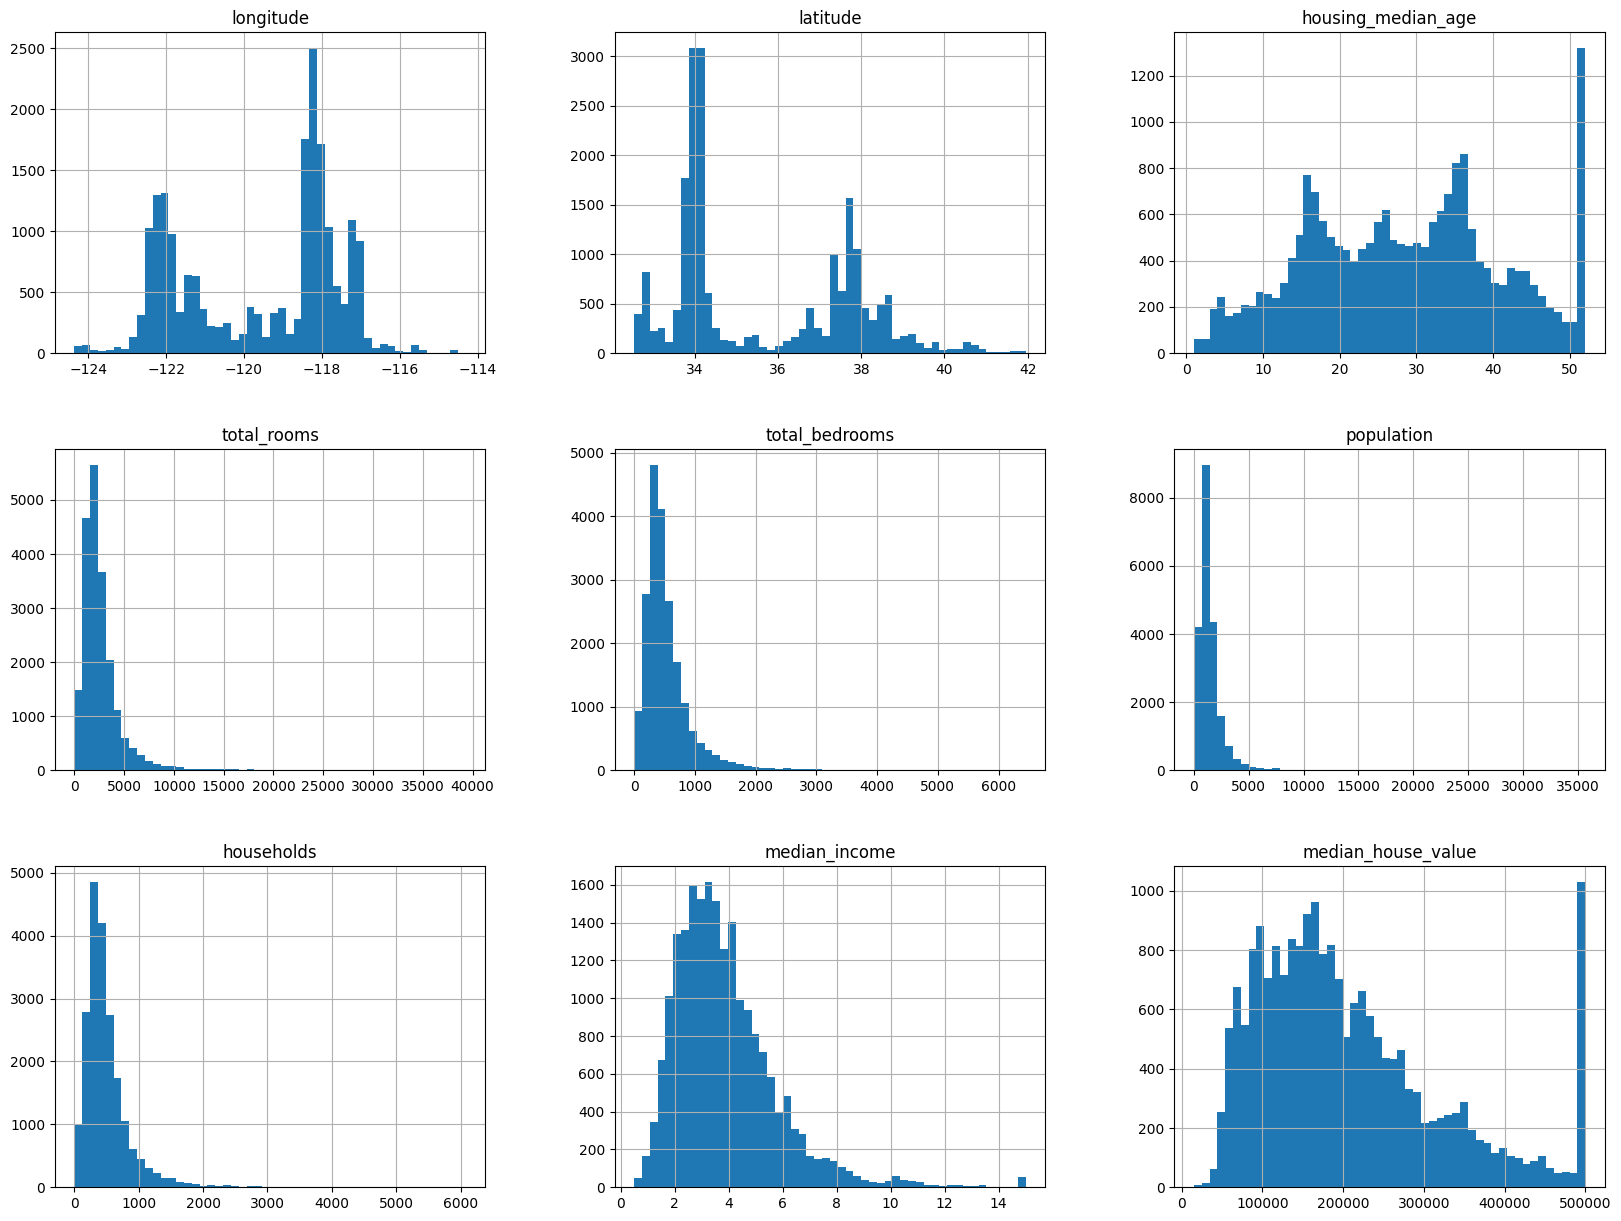

In [28]:
# Plot the distribution for all numerical columns
# bins=50 means to divide the range of values into 50 equal-sized bins
# figsize=(20, 15) means to set the figure size to width=20 and height=15
df.hist(bins=50, figsize=(20, 15))
plt.show()

Check for correlation between the features and the target variable using the `corr()` method of the dataframe. The `corr()` method computes pairwise correlation of columns, excluding NA/null values. The correlation coefficient ranges from -1 to 1. When it is close to 1, it means that there is a strong positive correlation; when the coefficient is close to -1, it means that there is a strong negative correlation; when it is close to zero, it means that there is no linear correlation.

Looking at the last row, we can see that the `median_house_value` has a strong positive correlation with the `median_income` (0.69). We can also see that the `median_house_value` has a weak correlation with the `longitude` (-0.05), `total_bedrooms` (0.05), `population` (-0.02), and `households` (0.07). We will consider removing the weakly correlated features in the preprocessing section.

/var/folders/3w/dx98vqrj12b47sl1fz6810rh0000gn/T/ipykernel_49330/1321278186.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


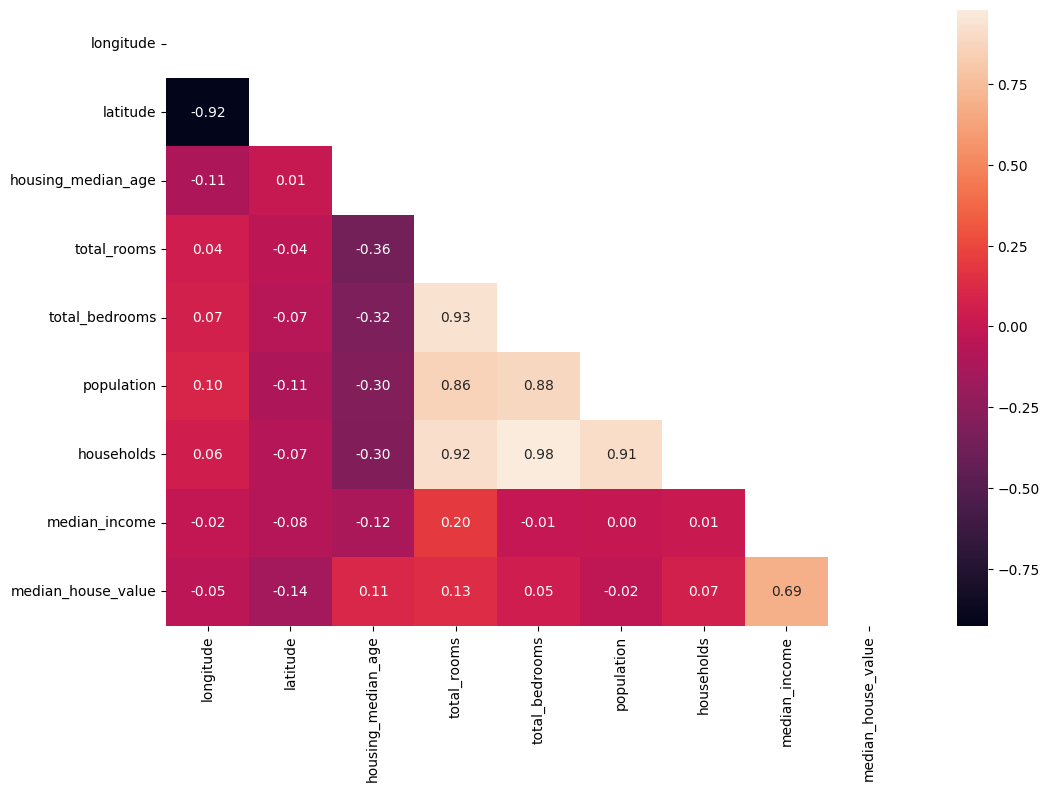

In [29]:
# Create a figure
plt.figure(figsize=(12, 8))

# Compute the correlation matrix using the `.corr()` method
correlation_matrix = df.corr()

# Create a mask to block the upper triangle of the correlation matrix
# as it is a mirror image of the lower triangle
# use `np.triu()` to create an upper triangle matrix of True and False
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap using seaborn's `heatmap()` function
# set `annot=True` to show the correlation values on the heatmap
# set `fmt='.2f'` to round the correlation values to 2 decimal places
# set `mask=mask` to block the upper triangle of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', mask=mask)

# show the plot
plt.show()


The correlation matrix can also be viewed as a dataframe to see the correlation coefficients of all the features with each other. Execute the cell below to view the correlation matrix as a dataframe.

In [30]:
correlation_matrix

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035      -0.079809   
housing_median_age       -0.320451   -0.296244   -0.302916      -0.119034   
total_rooms               0.930380    0.857126    0.918484       0.198050   
total_bedrooms            1.000000    0.877747    0.979728      -0.007723   
population                0.877747    1.000000    0.907222       0.004834   
households                0.979728    0.907222    1.000000       0.013033   
median_income            -0.007723    0.004834    0.013033       1.000000   
median_house_value        0.049686   -0.024650    0.065843       0.688075   

                    median_house_value  
longitude                    -0.045967  
latitude                     -0.144160  
housing_median_age            0.105623  
total_rooms                   0.134153  
total_bedrooms                0.049686  
population                   -0.024650  
households                    0.065843  
median_income                 0.688075  
median_house_value            1.000000

We can extract the correlation coefficients of the features with the target variable by selecting the column named `median_house_value` from the correlation matrix dataframe. We have sorted that column in descending order to see the features with the highest correlation with the target variable.

In [31]:
house_value_corr = correlation_matrix['median_house_value'].sort_values(ascending=False)
print(house_value_corr)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


View the correlation between the numerical columns in a Pandas DataFrame using scatter plots. This allows us to visualize linear and non-linear relationships between the features and target if any exists. The plots are generated using the `pairplot()` method of seaborn library. We are using it just to plot the numerical columns against the `median_house_value` column. You can also use the `pairplot()` method to plot all the columns in the dataframe by removing the `x_vars` and `y_vars` parameters from the method. `plot_kws` is a dictionary of keyword arguments that are passed to the scatter plot function inside `pairplot()` method. We are using it to set `alpha` to 0.5 to make the points more transparent.

We can see that the scatter plot for `median_income` and `median_house_value` show a strong positive correlation where the points are have a linear relationship. While the scatter plots for `housing_median_age`, `longitude`, and `latitude`,  show a weak correlation where the points are spread across the plot.

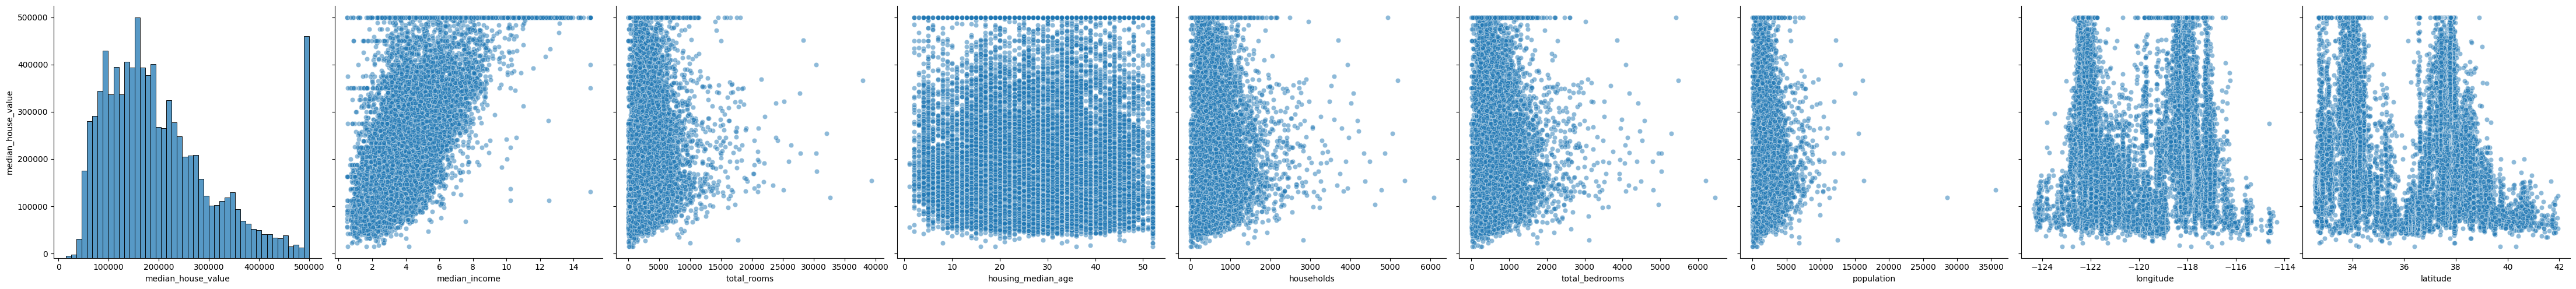

In [32]:
# Plot the scatter plot between column pairs
sns.pairplot(df, x_vars=house_value_corr.index, y_vars=['median_house_value'], height=5, plot_kws={'alpha': 0.5})

Check the correlation between the location of the houses and the median house value via longitude and latitude. We will use the `plotly.express` library to plot the geographical data. The `scatter_mapbox()` function creates a scatter plot on a map. The `px.scatter_mapbox()` function takes the dataframe as the first argument and the column names of the latitude and lonitude columns as the second and third arguments. The `color` parameter is used to specify the column to be used for coloring the points, which is the median house value in this case. The `hover_data` parameter is used to specify the column data to show when the mouse hover over a pont. The `mapbox_style` parameter is used to specify the style of the map.

This plot is interactive. You can zoom in and out of the map, pan around, and hover over the points to see the data values.

We can see that there are high density of expensive houses in the Bay Area and Los Angeles area, and also a relatively dense expensive houses in the San Diego area. We can see that as we move away from the coast, the house prices decrease. So, we can use the `ocean_proximity` column as a feature to predict the house prices. Additionally, we can create a new feature by using the `longitude` and `latitude` columns to compute the distance from the closest dense areas of expensive houses. This can be done by simply picking a reference point (anchor) from each of the dense expensive area, and computing a given point's distance from the closest anchor. We will perform these steps in the preprocessing section.

In [33]:
# Use plotly express to plot the scatter plot on a map
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="median_house_value",
                        width=800, height=600,
                        hover_data=df.columns,
                        mapbox_style="open-street-map",
                        zoom=5,
                        )
fig.show()

# Data Preprocessing

Data splitting. We are given one CSV file containing all the data. We will split the data into training, validation, and test sets.
- The training dataset is used to train the machine learning model. The model learns the patterns and relationships within the data from this set. The model adjusts its parameters to minimize the difference between its predictions and the ground truth values provided with this dataset.
- The validation dataset is used to assess the model's performance during training and guide the adjustment of the hyperparameters. Hyperparameters are training/model configurations that the programmer can manually adjust. Since the validation dataset is an independent dataset not used in directly tuning the model's internal parameters, we can use it to assess whether a model is under-fitting or over-fitting.
- The test dataset is kept separate from both the training and validation sets. It is used to assess the final performance of the trained model on unseen data. The test set provides an unbiased evaluation of the model's generalization to new, previously unseen examples.

Building pipelines to preprocess the data. The preprocessing pipeline provides a systematic and efficient way to streamline and automate the data preprocessing steps. It ensures consistent application of preprocessing steps to training, validation, and test data, enhancing model reproducibility, readability, and ease of deployment. In this section, we will build a preprocessing pipeline to perform the following steps:
 - Fill nan values with nearest neighbors
 - Scale the data using logarithmic transformation to reduce the skewness of the data
 - Standardize features by removing the mean and scaling to unit variance using StandardScaler
 - Encode string categorical features using OneHotEncoder
 - Compute new feature based on latitude and longitude (distance from dense area)
 - Drop low correlation features


Reload the data into a Pandas DataFrame to reset the changes made to the dataframe in the previous section. Additionally, we will declare variables to store the names of the numerical, categorical, and label (target) columns.

In [34]:
# TODO: reload the dataset
csv_path = os.path.join('.','dataset','housing','housing.csv')# TODO: variable for dataset path
df = pd.read_csv(csv_path)

# Declare the categorical, numerical, and target column
cat_features = ['ocean_proximity']
num_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
all_features = cat_features + num_features

label = 'median_house_value'

Split the data into training, validation, and test sets. The training set will be used to train the model, the validation set will be used to evaluate the model during the training process, and the test set will be used to test the final model.

We will be using Scikit-Learn's `train_test_split` function to split the data into training, validation, and test sets. The `train_test_split` function takes in the dataframe as argument and returns the training set and test set. We will further split the training set into training and validation sets. The final split is 60% training, 20% validation, and 20% test.

In [35]:
# TODO: use a random seed so that we can reproduce the results
# this is important when you want to compare different models in different executions
random_seed = 2508

# TODO: split the data into training and test sets. 80/20 split.
train_set, test_set = train_test_split(df, test_size=0.2, random_state=random_seed)

# TODO: split the data into training and validation sets.
# 75/25 split of the training set, which is 60/20 of the original set.
train_set, valid_set = train_test_split(train_set, test_size=0.25, random_state=random_seed)

Separate the feature columns from the label column

In [36]:
# TODO: separate the features and labels in the training, validation, and test sets
train_X, train_y = train_set.drop(columns=['median_house_value']),train_set['median_house_value']
valid_X, valid_y = valid_set.drop(columns=['median_house_value']),valid_set['median_house_value']
test_X, test_y = test_set.drop(columns=['median_house_value']),test_set['median_house_value']

Check the feature distribution in the training, validation, and test sets. We want to ensure that the distribution is similar in all the sets.

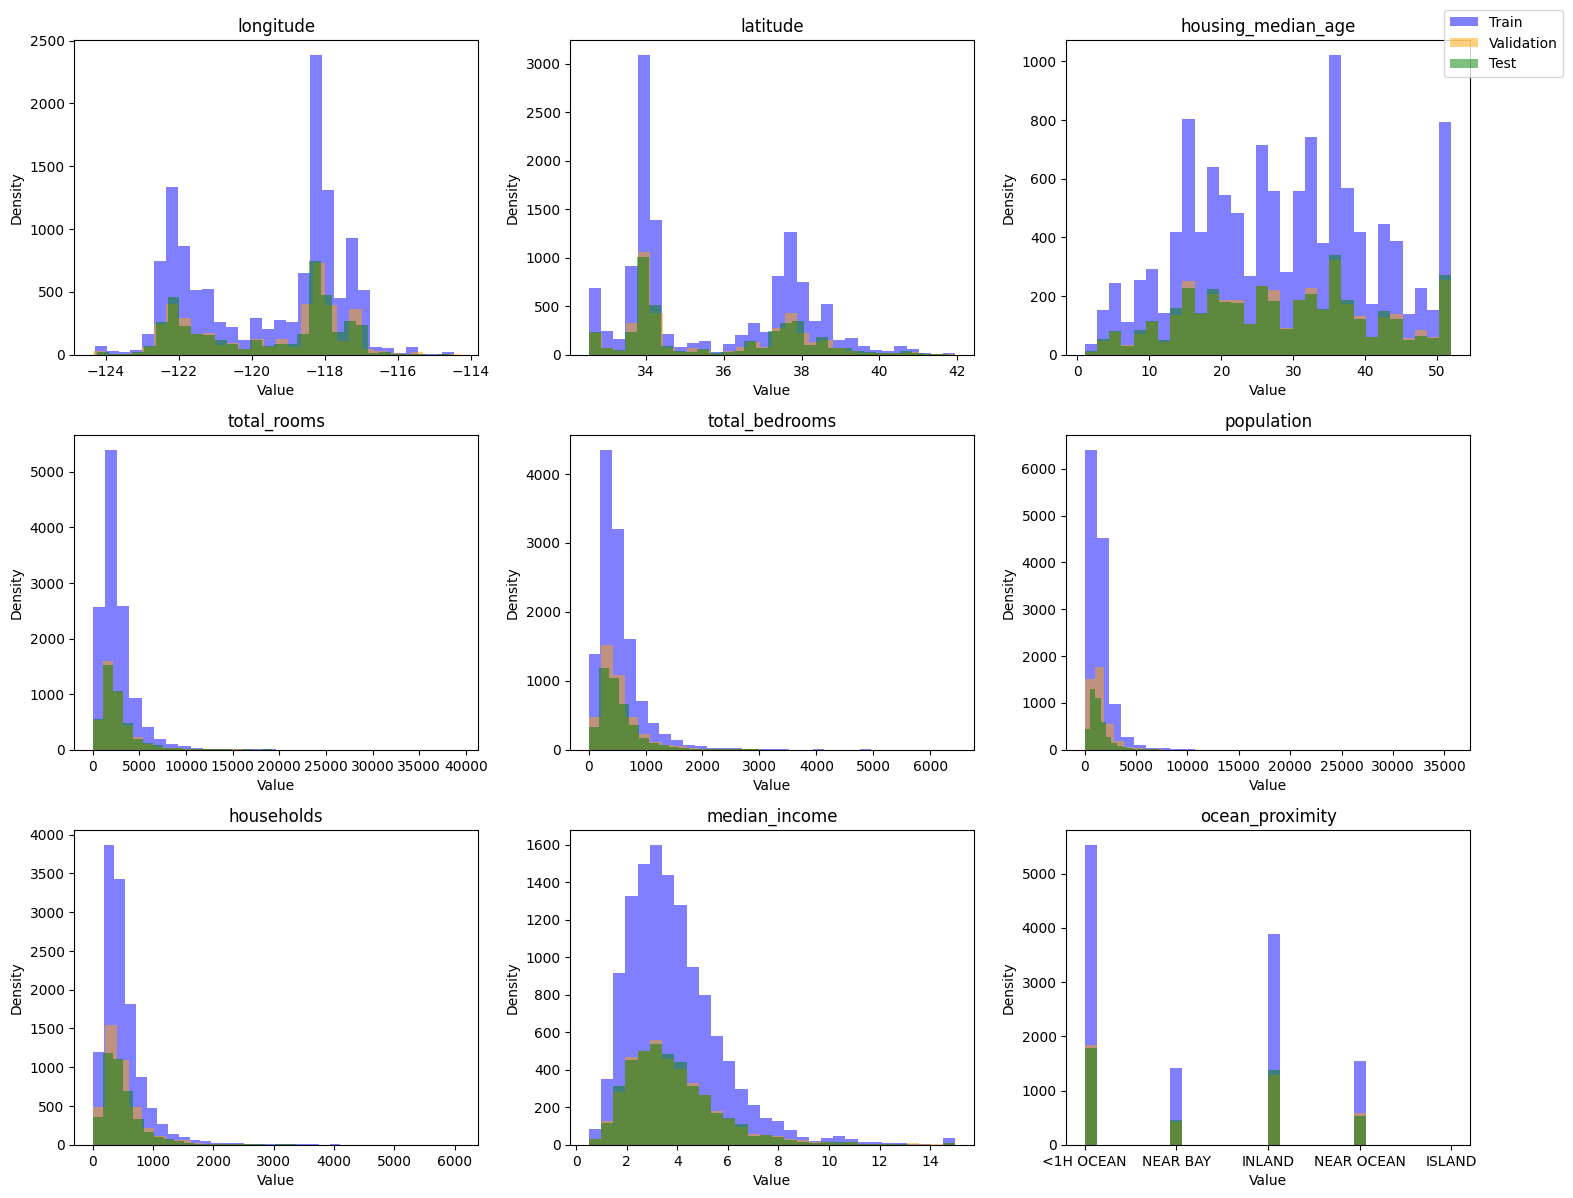

In [37]:
# Check the distribution of the training set, validation set, and test set
# For each feature, overlay the histograms of the three sets on the same subplot

# TODO: create a figure with 3 rows and 3 columns


fig, axes = plt.subplots(3, 3, figsize=(15, 12)) 
features = train_X.columns

axes = axes.ravel() # flattens axes into 1 dimensional array. 


# TODO: for each feature, plot the histograms of the three sets on the same subplot
for ax, col in zip(axes, features ):
    # plots the training set
    ax.hist(train_X[col], bins=30, alpha=0.5, label='Train', color='blue')

    # plots the validation set
    ax.hist(valid_X[col], bins=30, alpha=0.5, label='Validation', color='orange')

    # plots the test set
    ax.hist(test_X[col], bins=30, alpha=0.5, label='Test', color='green')

    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')


# TODO: add a legend to the figure anchor to the top right corner
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper right')

# TODO: use `plt.tight_layout()` to adjust the padding between and around subplots.
plt.tight_layout()

plt.show()


Check the label distribution in the training, validation, and test sets.

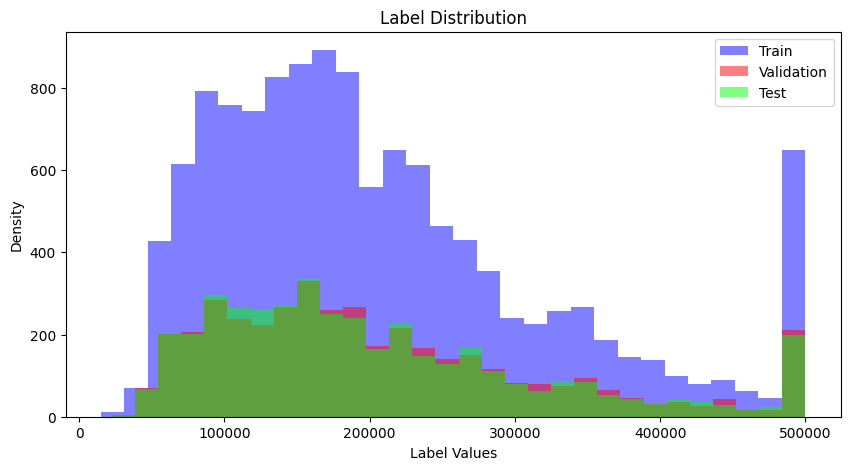

In [38]:
# TODO: check the label distribution of the training set, validation set, and test set
# overlay the histograms of the three sets

plt.figure(figsize=(10, 5))

label = 'Label Distribution' 

plt.hist(train_y, bins=30, alpha=0.5, label='Train', color='blue')
plt.hist(valid_y, bins=30, alpha=0.5, label='Validation', color='red')
plt.hist(test_y, bins=30, alpha=0.5, label='Test', color='lime')

plt.xlabel('Label Values')
plt.ylabel('Density')


plt.title(label)
plt.legend()
plt.show()


## Create Preprocessing Pipeline

 - Fill nan values with nearest neighbors
 - Scale the data using logarithmic transformation to reduce the skewness of the data
 - Standardize features by removing the mean and scaling to unit variance using StandardScaler
 - Encode string categorical features using OneHotEncoder
 - Compute new feature based on latitude and longitude (distance from dense area)
 - Drop low correlation features

Below we will create some custom data transformers, which will be used in the preprocessing pipeline. These custom transformers inherits `BaseEstimator` and `TransformerMixin`. These classes are provided by scikit-learn to help in creating custom transformers and estimators that seamlessly integrate with scikit-learn's pipeline.

`BaseEstimator` is the base class for all scikit-learn estimators. An estimator is an object that fits a model based on some training data and is capable of inferring some properties on new data. It can be, for instance, a classifier or a regressor. All estimators implement the fit method (`fit(X, y)`).

`TransformerMixin` is a mixin class for transformers in scikit-learn. A transformer implements the `fit_transform` methods. It provides a default implementation for the `fit_transform` method, which combines fitting and transforming in a single step.

Custom feature engineering class, `MinDistanceFromAnchors`, finds the nearest anchor (based on latitude and longitude information)
        for each given data point and output their Euclidean distance. This transformer is designed to be used within a scikit-learn preprocessing pipeline.

In [39]:
# Feature Engineering to create new features based on latitude and longitude
class MinDistanceFromAnchors(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        '''Finds the nearest anchor (based on latitude and longitude information)
        for each given data point and output their Euclidean distance
        '''
        self.anchors = [(37.38, -122.21), # Bay Area
                        (33.99, -118.5), # Los Angeles
                        (32.82, -117.31), # San Diego
                        ]
        self.num_anchors = len(self.anchors)

    def fit(self, X: np.ndarray, y: np.ndarray=None) -> 'MinDistanceFromAnchors':
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        '''Calculate the euclidean distance between each data point and each anchor,
        store the distances in the distances matrix, and filter to nearest anchor distance only.
        '''

        # initialize the distances matrix
        distances = np.zeros((X.shape[0], self.num_anchors))

        # calculate the euclidean distance between each data point and each anchor
        for i in range(self.num_anchors):
            lat_long_points = X.astype(float)
            anchor = np.array(self.anchors[i])
            distances[:, i] = np.sqrt(np.sum((lat_long_points - anchor)**2, axis=1))

        # find the minimum distance out of the distances to the three anchors
        min_distances = np.min(distances, axis=1)

        return min_distances.reshape(-1, 1)


`LogScaler` is a custom transformer that scales the data using logarithmic transformation to reduce the skewness of the data. The `FunctionTransformer` class is used to create a transformer that applies a function to the data. The `FunctionTransformer` class takes in the function to be applied as the first argument.

In [40]:
# TODO: create a custom transformer using np.log() to log transform the data
log_scaler = FunctionTransformer(func=np.log, validate=True)

Sets up four preprocessing pipelines. The pipelines consist of several sequential steps, each represented by a tuple with a name and a corresponding transformer.
1. `lat_long_pipeline` is a pipeline for the `latitude` and `longitude` columns. It consists of the `MinDistanceFromAnchors` transformer, which calculates the Euclidean distance from data points to their nearest anchor based on latitude and longitude information. The `StandardScaler` transformer is used to standardize the data by removing the mean and scaling to unit variance.
2. `log_std_pipeline` is a pipeline for the numerical columns with skew distribution. It consists of the `KNNImputer` to fill in any missing values. The `LogScaler` transformer, which scales the data using logarithmic transformation to reduce the skewness of the data. The `StandardScaler` transformer is used to standardize the data by removing the mean and scaling to unit variance.
3. `std_pipeline` is a pipeline for the remaining numerical columns. It consists of the `KNNImputer` to fill in any missing values. The `StandardScaler` transformer is used to standardize the data by removing the mean and scaling to unit variance.
4. `cat_pipeline` is a pipeline for the categorical columns. It consists of the `OneHotEncoder` transformer, which encodes categorical features as a one-hot numeric array. `sparse=False` is used to return a dense array representation in numpy.

In [41]:
# Latitude and longitude preprocess pipeline
lat_long_pipeline = Pipeline([
    ('min_distance_from_anchors', MinDistanceFromAnchors()),
    ('std_scaler', StandardScaler()),
])

# Create the preprocess pipeline for log scaling and standard scaling features
log_std_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=10, weights='distance')),
        ('log_scaler', log_scaler),
        ('std_scaler', StandardScaler()),
    ])

# Create the preprocess pipeline for standard scaling features
std_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=10, weights='distance')),
        ('std_scaler', StandardScaler()),
    ])

# Create the preprocess pipeline for categorical features
cat_pipeline = Pipeline([
        ('one_hot_encoding', OneHotEncoder(sparse=False, categories=[['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR OCEAN', 'NEAR BAY']])),
    ])

We will test out the pipelines on the training set. We will use the `fit_transform` method to fit the pipeline to the training set and transform the training set.

In [42]:
# make a copy of the training set to test the preprocess pipelines
train_X_copy = train_X.copy()

In [43]:
# test out the lat_long_pipeline
lat_log_X = train_X_copy[['latitude', 'longitude']]
distances = lat_long_pipeline.fit_transform(lat_log_X)

# add the new feature to the training set
train_X_copy['distance_from_anchor'] = distances

# using plotly express to plot the scatter plot on a map using the new feature as the color
fig = px.scatter_mapbox(train_X_copy, lat="latitude", lon="longitude", color="distance_from_anchor",
                        width=800, height=600,
                        hover_data=train_X_copy.columns,
                        mapbox_style="open-street-map",
                        zoom=5,
                        )
fig.show()

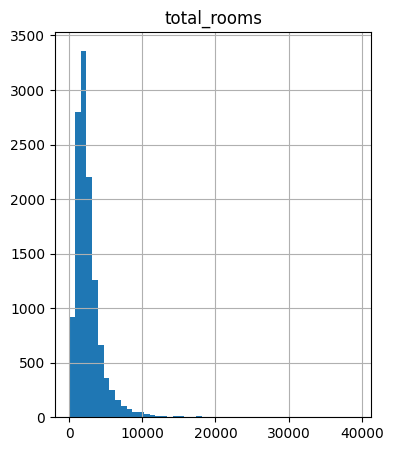

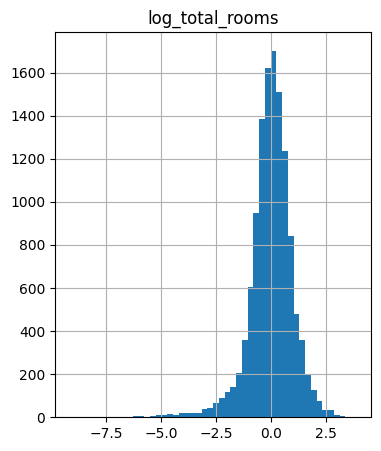

In [44]:
# testing out the log_std_pipeline
log_std_X = train_X_copy[['total_rooms']]
log_std_X_transformed = log_std_pipeline.fit_transform(log_std_X)

# add the new features to the training set
train_X_copy['log_total_rooms'] = log_std_X_transformed[:, 0]

# plot the histograms of the new features
train_X_copy[['total_rooms']].hist(figsize=(20,5), bins=50, layout=(1,4))
plt.show()
train_X_copy[['log_total_rooms']].hist(figsize=(20,5), bins=50, layout=(1,4))
plt.show()

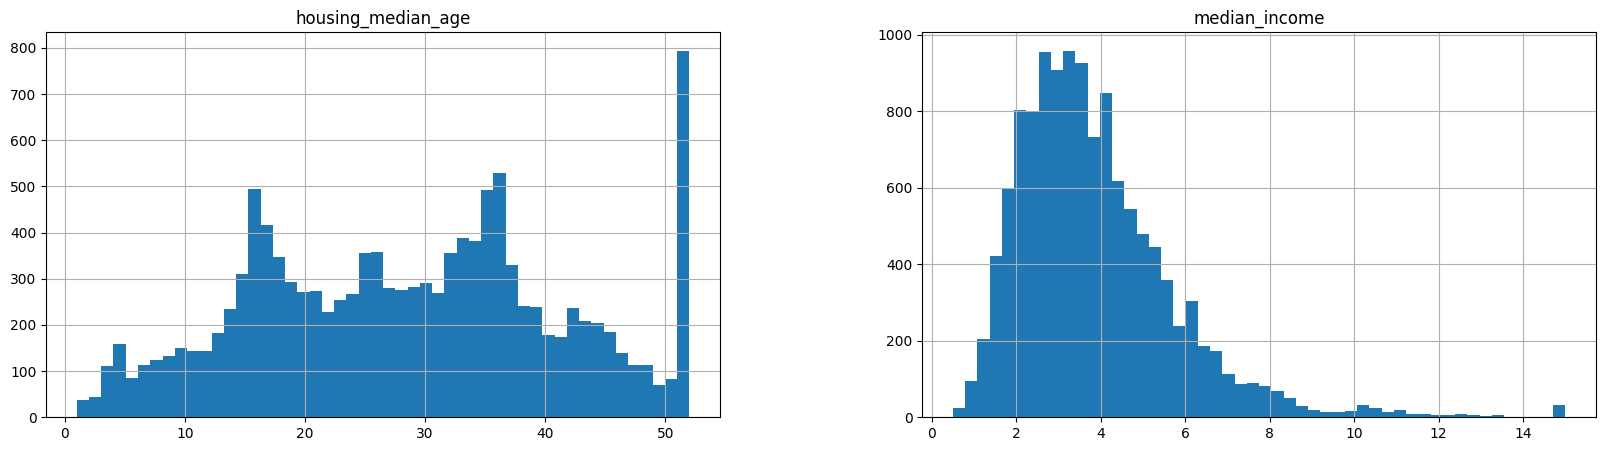

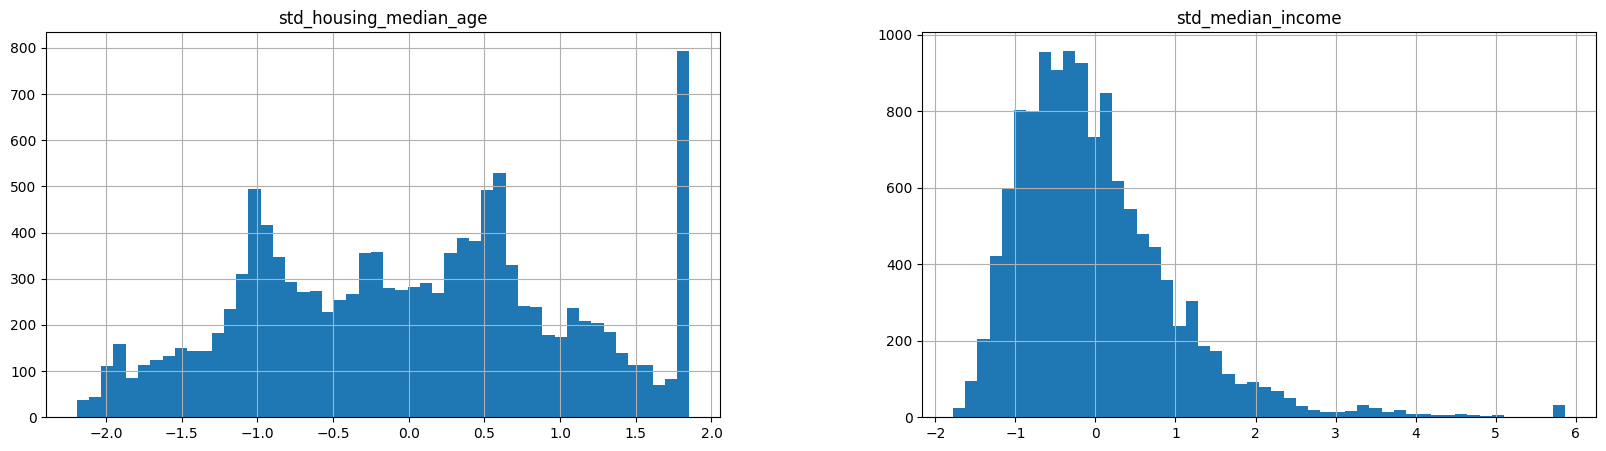

In [45]:
# testing out the std_pipeline
log_std_X = train_X_copy[['housing_median_age', 'median_income']]
log_std_X_transformed = std_pipeline.fit_transform(log_std_X)

# add the new features to the training set
train_X_copy['std_housing_median_age'] = log_std_X_transformed[:, 0]
train_X_copy['std_median_income'] = log_std_X_transformed[:, 1]

# plot the histograms of the new features
train_X_copy[['housing_median_age', 'median_income']].hist(figsize=(20,5), bins=50, layout=(1,2))
plt.show()
train_X_copy[['std_housing_median_age', 'std_median_income']].hist(figsize=(20,5), bins=50, layout=(1,2))
plt.show()

In [46]:
# test out the cat_pipeline
cat_X = train_X_copy[['ocean_proximity']]
cat_X_transformed = cat_pipeline.fit_transform(cat_X)

# print out the first five rows with the categories
print('Value before transformation:')
print(cat_X[:5], end='\n==================\n')

print('Value after transformation:')
print(cat_pipeline['one_hot_encoding'].categories_)
print(cat_X_transformed[:5])

Value before transformation:
      ocean_proximity
15193       <1H OCEAN
1415         NEAR BAY
11481       <1H OCEAN
19628          INLAND
724          NEAR BAY
Value after transformation:
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR OCEAN', 'NEAR BAY'],
      dtype=object)]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


/Users/edward/Documents/157a_Homework_1/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Combine all the pipelines using `ColumnTransformer`. `ColumnTransformer` allows us to apply different preprocessing steps to different columns in the dataset. It is particularly useful when we have a dataset with data types or when we want to apply specific transformations to specific subsets of features.

`ColumnTransformer` takes in a list of tuples, where each tuple contains a name, a transformer, and a list of columns to which the transformer should be applied. The `remainder` parameter is set to `'passthrough'` to ensure that the columns not specified in the list of tuples are passed through without any transformations. Or, we can set `remainder` to `'drop'` to drop the columns not specified in the list of tuples.

In [47]:
# TODO: create a pipeline with the ColumnTransformer

categorical_features = ['ocean_proximity']

lat_long_features = ['latitude','longitude']

log_std_features = ['total_rooms']

std_pipeline_features = ['housing_median_age','median_income']

preprocess_pipeline = ColumnTransformer([
        ('lat_long', lat_long_pipeline, lat_long_features), 
        ('log_std', log_std_pipeline, log_std_features), 
        ('std', std_pipeline, std_pipeline_features), 
        ('cat', cat_pipeline, categorical_features)
    ], remainder='drop')


Use the full pipeline to fit on the training data, then transform the training and validation data.

In [48]:
# TODO: fit the pipeline to the training set and transform it

train_X_copy2 = preprocess_pipeline.fit_transform(train_X)

# TODO: transform the validation set
valid_X_copy2 = preprocess_pipeline.fit_transform(valid_X)


/Users/edward/Documents/157a_Homework_1/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/Users/edward/Documents/157a_Homework_1/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



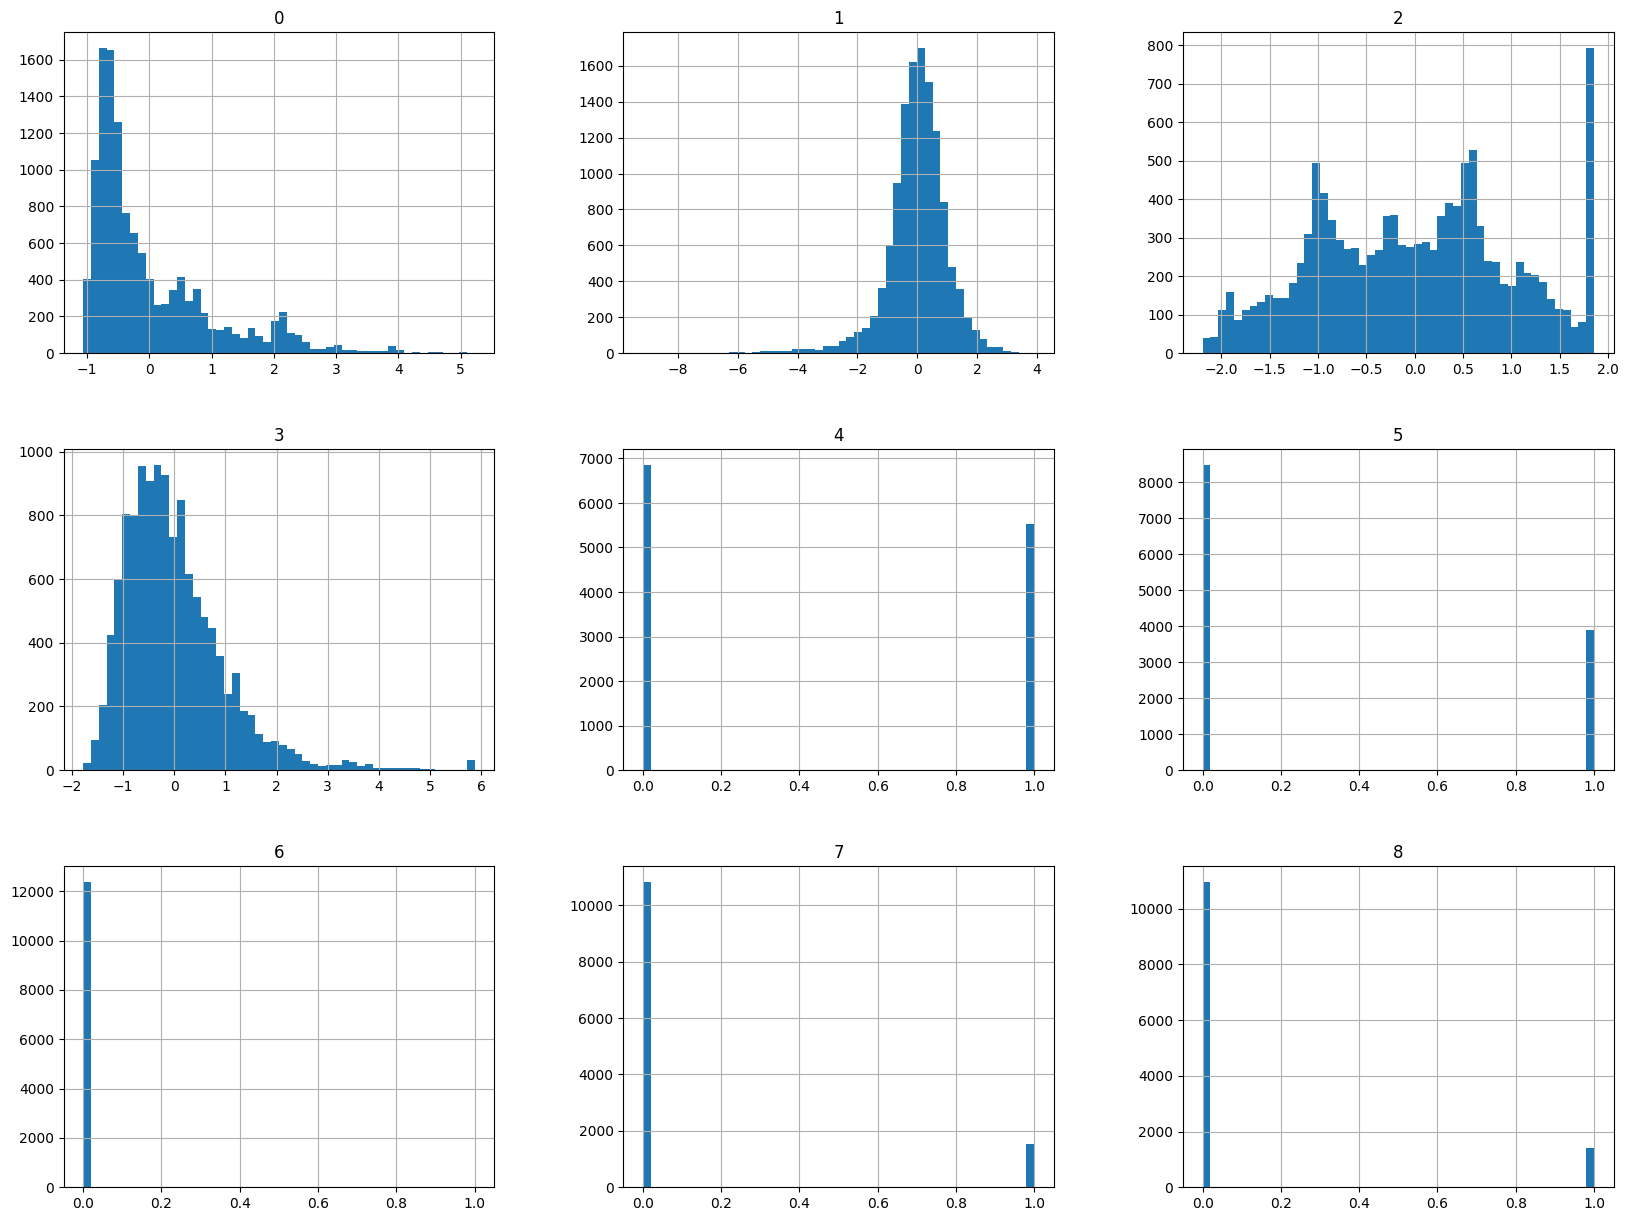

In [49]:
# quick check on the features of the training set
# should contains features `distance from anchor`, `total_rooms`,
# `housing_median_age`, `median_income`, and five features from one-hot `ocean_proximity`.
pd.DataFrame(train_X_copy2).hist(bins=50, figsize=(20, 15))
plt.show()

# Train and Evaluate Models

This perhaps is the easier part of the workflow in terms of coding. Scikit-learn provides a wide range of machine learning tools that we can use to train and evaluate on our data. Their APIs are very consistent. We can use the same code to train and evaluate different models by simply changing the model class.

Before we start, we will implement an evaluation function. This function `predict_and_print_metrics` takes a regression model, input features (X), target values (y), and a dataset name. It then predicts the target values using the model, calculates and prints the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE).

MAE (Mean Absolute Error):
- MAE is calculated as the mean of absolute differences between predicted and true values.
- It treats all errors equally, regardless of their magnitude.
- $MAE = \frac{1}{N}\sum_{i=1}^{N} |y_i - \hat{y_i}|$ where $y_i$ is true value of sample $i$, $\hat{y_i}$ is the model prediction value of sample $i$, ad $N$ is the number of samples

RMSE (Root Mean Squared Error):
- RMSE is calculated as the square root of the mean of squared differences between predicted and true values.
- It penalizes large errors more heavily than small ones.
- $RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y_i})^2}$ where $y_i$ is true value of sample $i$, $\hat{y_i}$ is the model prediction value of sample $i$, ad $N$ is the number of samples





In [50]:
# TODO: import the mean squared error and mean absolute error metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error

# TODO: create a function to predict and print the metrics
def predict_and_print_metrics(model, X: np.ndarray, y: np.ndarray, name: str) -> None:
    # predict the target values
    y_pred = model.predict(X)

    # Compute MAE
    mae = mean_absolute_error(y, y_pred)
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f'{name} MAE: {mae}')
    print(f'{name} RMSE: {rmse}')


Train a Linear Regression model. The training can be done in three lines of code. First, we import the model class from the Scikit-Learn library. Then, we create an instance of the model class. Third, we call the `fit` method of the model instance to train the model. The `fit` method takes in the training features and labels as arguments. The model learns the patterns and relationships within the data. Then, we use the trained model to predict the target values for the training and validation set, and we evaluate the model using the evaluation metrics mentioned above.

In [51]:
# TODO: import the linear regression model
from sklearn.linear_model import LinearRegression


# TODO: instantiate and train the model
lin_reg = LinearRegression() 

lin_reg.fit(train_X_copy2, train_y)


# TODO: evaluate the model on the training set and validation set

predict_and_print_metrics(lin_reg, train_X_copy2, train_y, "Training")
predict_and_print_metrics(lin_reg, valid_X_copy2, valid_y, "Validation")


Training MAE: 53064.25780448157
Training RMSE: 72755.03474119007
Validation MAE: 51838.29758684676
Validation RMSE: 70467.74134528502


We will train and evaluate another model (K-neighbors regressor). We will use the same code to train and evaluate different models by simply changing the model class.

In [52]:
# TODO: import the K-neighbors regressor
from sklearn.neighbors import KNeighborsRegressor


# TODO: instantiate and train the model
neigh = KNeighborsRegressor()

# Fit the model to the training data
neigh.fit(train_X_copy2, train_y)


# TODO: evaluate the model on the training set and validation set

predict_and_print_metrics(neigh, train_X_copy2, train_y, "Training")
predict_and_print_metrics(neigh, valid_X_copy2, valid_y, "Validation")


Training MAE: 38090.29475129199
Training RMSE: 55424.700316400216
Validation MAE: 45924.06337209303
Validation RMSE: 66900.82537484818


In the case where the model has hyperparameters, we can either write our own code to search for the best hyperparameters or use Scikit-Learn's `GridSearchCV` class to search for the best hyperparameters. We start off by writing our own code to search for the best hyperparameters.

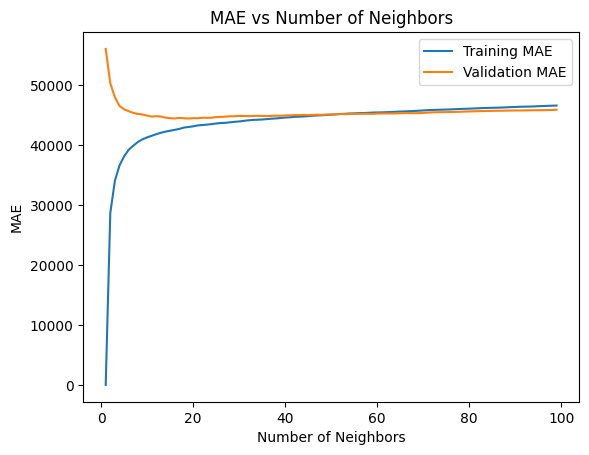

Neighbors: 1, Train MAE: 0.0, Validation MAE: 55982.79893410853
Neighbors: 2, Train MAE: 28661.119549418603, Validation MAE: 50272.79990310078
Neighbors: 3, Train MAE: 34027.568583118, Validation MAE: 47916.01049741601
Neighbors: 4, Train MAE: 36571.57677244832, Validation MAE: 46473.474866763565
Neighbors: 5, Train MAE: 38090.29475129199, Validation MAE: 45924.06337209303
Neighbors: 6, Train MAE: 39182.58885120586, Validation MAE: 45606.05216408269
Neighbors: 7, Train MAE: 39863.24974621631, Validation MAE: 45319.737022425245
Neighbors: 8, Train MAE: 40483.156895994834, Validation MAE: 45156.232951792634
Neighbors: 9, Train MAE: 40921.20403567327, Validation MAE: 45061.527939276486
Neighbors: 10, Train MAE: 41247.121390503875, Validation MAE: 44873.56901647287
Neighbors: 11, Train MAE: 41509.15013507165, Validation MAE: 44709.71758280479
Neighbors: 12, Train MAE: 41778.04079861111, Validation MAE: 44774.05113452842
Neighbors: 13, Train MAE: 42013.96612875174, Validation MAE: 44716.055

In [53]:
# Train a k-neighbors regressor with search for the best hyperparameters
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

# TODO: create lists to store the train and validation scores
train_scores =[]
valid_scores =[]

# TODO: create a list of hyperparamters to try out
neighbors = list(range(1, 100))

# TODO: loop through the parameters and fit the model
# evaluate the model on the train set and validation set
for neighbor in neighbors:
    neigh = KNeighborsRegressor(n_neighbors=neighbor)
    neigh.fit(train_X_copy2, train_y)

    # evaluate the model on the train set
    train_y_pred =neigh.predict(train_X_copy2)
    train_mae = mean_absolute_error(train_y, train_y_pred)
    train_scores.append(train_mae)

    # evaluate the model on the validation set
    valid_y_pred = neigh.predict(valid_X_copy2)
    valid_mae = mean_absolute_error(valid_y, valid_y_pred)
    valid_scores.append(valid_mae)

# TODO: plot the learning curves
plt.plot(neighbors, train_scores, label='Training MAE')
plt.plot(neighbors, valid_scores, label='Validation MAE')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Number of Neighbors')
plt.show()

# TODO: print the neighbors and the corresponding scores
for neighbor, train_score, valid_score in zip(neighbors, train_scores, valid_scores):
    print(f'Neighbors: {neighbor}, Train MAE: {train_score}, Validation MAE: {valid_score}')


Use `GridSearchCV` to search for the best hyperparameters. `GridSearchCV` takes in the model class, hyperparameter grid, evaluation metric (scorer), and number of folds as arguments. It then searches for the best hyperparameters based on the evaluation metric. We will use the same evaluation metric as before, MAE. We will combine the training and evaluation data into one dataset. This is because `GridSearchCV` uses cross-validation to evaluate the model. We will use 5-fold cross-validation, which means that the dataset will be split into 5 folds. The model will be trained and evaluated 5 times, each time using a different fold as the evaluation set. The final evaluation metric will be the average of the 5 evaluations.

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

# TODO: combine the train and validation sets for GridSearchCV
train_valid_X =np.vstack([train_X_copy2, valid_X_copy2])
train_valid_y =np.hstack([train_y, valid_y])


# TODO: Specify the parameter grid for the grid search
neighbors = list(range(1, 100))

param_grid = {'n_neighbors': neighbors}


# TODO: Define your MAE evaluation metric function
def custom_metric(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return mae

# TODO: Make the metric a scorer using make_scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # We use negative MAE to maximize (since GridSearchCV maximizes the scorer)


# TODO: Create the KNeighborsRegressor
neigh = KNeighborsRegressor()

# TODO: Create the GridSearchCV object with custom scoring
grid_search = GridSearchCV(
    estimator=neigh,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=5  
)

# TODO: Fit the grid search to your data

grid_search.fit(train_valid_X, train_valid_y)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Model: {best_model}\n")
print(f"Best Parameters: {best_params}\n")

best_index = grid_search.best_index_
print('All mean test scores: \n', grid_search.cv_results_['mean_test_score'], '\n')
print('Best hyperparamter mean test scores: \n', grid_search.cv_results_['mean_test_score'][best_index])


Best Model: KNeighborsRegressor(n_neighbors=16)

Best Parameters: {'n_neighbors': 16}

All mean test scores: 
 [-56716.67153921 -50750.91012464 -48440.40537527 -47166.55186441
 -46616.92096866 -46245.61888086 -45832.14471555 -45589.31495122
 -45358.59468615 -45263.47055242 -45195.48217941 -45065.2660878
 -45079.02001408 -45058.773001   -44982.67745478 -44917.9683715
 -44932.11328052 -44950.8693294  -44968.61832242 -44991.51635124
 -44987.07410159 -44983.61899603 -45003.46242471 -45005.65776336
 -45050.14910409 -45079.3275513  -45104.42049358 -45070.68244751
 -45112.4760814  -45106.55528933 -45122.42992825 -45153.67327573
 -45167.89242566 -45178.95744893 -45226.64298313 -45229.81703609
 -45242.85473905 -45293.02281128 -45297.09005535 -45315.86948591
 -45340.40901828 -45388.81074805 -45415.48185665 -45460.97297552
 -45487.35021929 -45503.47488354 -45507.12172005 -45550.70730487
 -45573.96577298 -45581.50945032 -45606.52152577 -45623.08300495
 -45633.60486682 -45656.38946727 -45684.788741

# Putting it all together in a pipeline and export pipeline

We will now combine the preprocessing pipeline and the best model into one pipeline.

In [55]:
# Combine the preprocessing pipeline and the best model into a new pipeline
pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('model', best_model)
])

Save the pipeline using `joblib.dump` and load it back for predicting the test set

In [56]:
# Save the pipeline
joblib.dump(pipeline, './pipelines/house_price_pipeline.joblib')

['./pipelines/house_price_pipeline.joblib']

In [57]:
# Load the pipeline
pipeline = joblib.load('./pipelines/house_price_pipeline.joblib')

# Evaluate the pipeline on the test set
predict_and_print_metrics(pipeline, test_X, test_y, 'Test')


Test MAE: 43600.958333333336
Test RMSE: 62909.35045554556


Check to see how the model performs on the test set. We will see how much percentage the predictions deviate from the actual values.

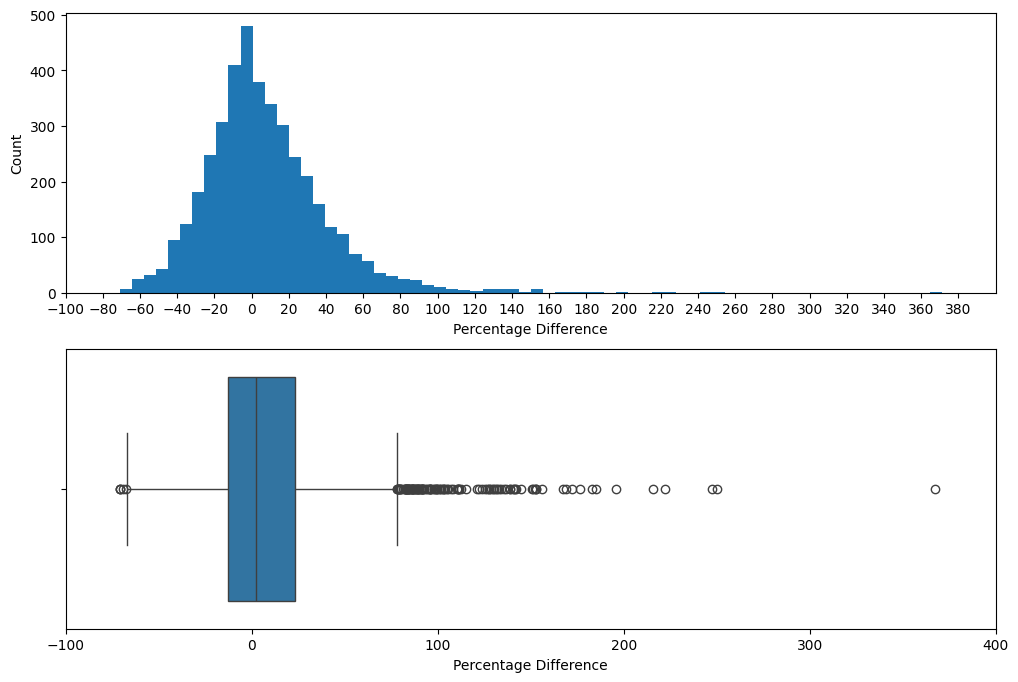

In [58]:
percentage_diff = (pipeline.predict(test_X) - test_y)/test_y * 100

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.hist(percentage_diff, bins=100)
plt.xlabel('Percentage Difference')
plt.ylabel('Count')
plt.xlabel('Percentage Difference')
plt.xlim(-100,400)
plt.xticks(np.arange(-100, 400, 20))

plt.subplot(2,1,2)
sns.boxplot(percentage_diff, orient='h')
plt.xlim(-100,400)
plt.xlabel('Percentage Difference')
plt.show()